# Import

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

# Calibrate Camera

#### first, calculate camera calibration matrix and distortion coefficients

In [2]:
def get_calibrate_camera_matrix():
    nx = 9
    ny = 6
    imgpaths = glob.glob('./camera_cal/*.jpg')

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for imgpath in imgpaths:
        img = mpimg.imread(imgpath)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            draw_img = cv2.drawChessboardCorners(gray, (nx, ny), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [3]:
mtx, dist = get_calibrate_camera_matrix()

#### undistort image with camera calibration matrix and distortion coefficients

In [4]:
def undistort_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

#### Example of undistorted image

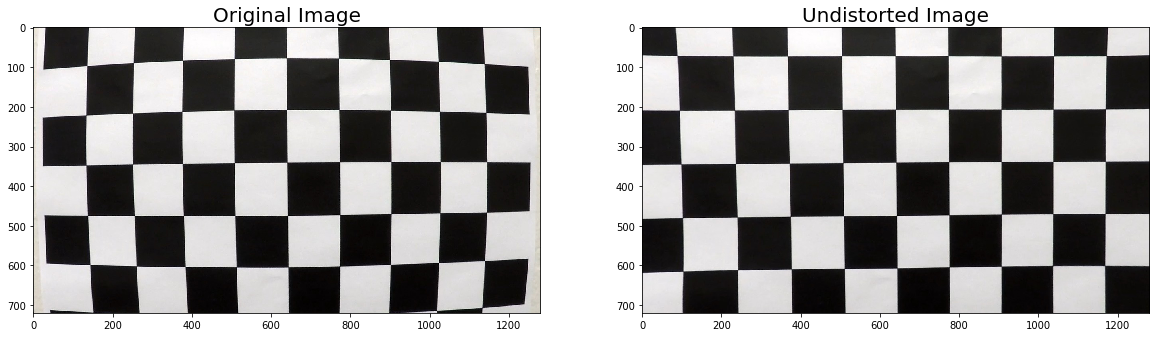

In [5]:
def visual_undistort_img(img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)

    undist_image = undistort_image(img)
    ax2.imshow(undist_image)
    ax2.set_title('Undistorted Image', fontsize=20)
    
test_image = mpimg.imread('./camera_cal/calibration1.jpg')
visual_undistort_img(test_image)

# Apply a distortion correction to raw images.

#### Correct  raw images

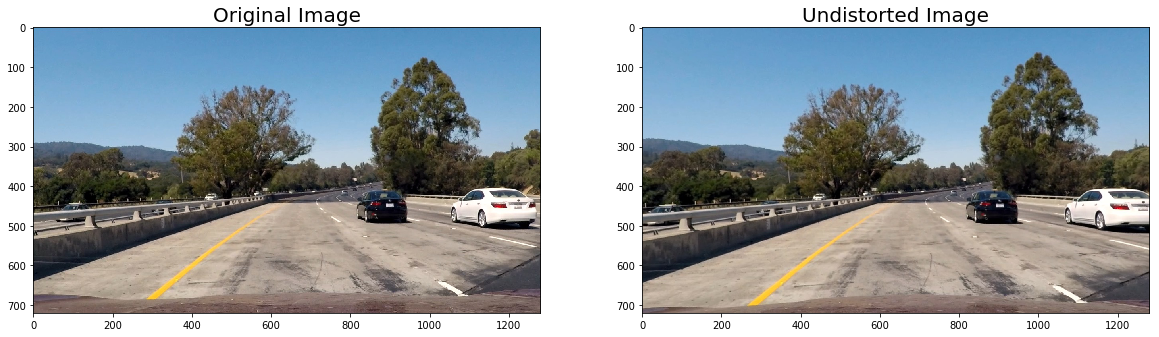

In [6]:
test_image = mpimg.imread('./test_images/test1.jpg')
visual_undistort_img(test_image)

In [8]:
def get_reversion_transformation_matrix(src, dst):
    return cv2.getPerspectiveTransform(dst, src)

def warper(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

In [7]:
def get_warp_points():
    src = np.float32([(575,464), (707,464), (258,682), (1049,682)])
    dst = np.float32([(450,0), (830,0), (450,720), (830,720)])
    return src, dst

In [9]:
src, dst = get_warp_points()
Minv = get_reversion_transformation_matrix(src, dst)

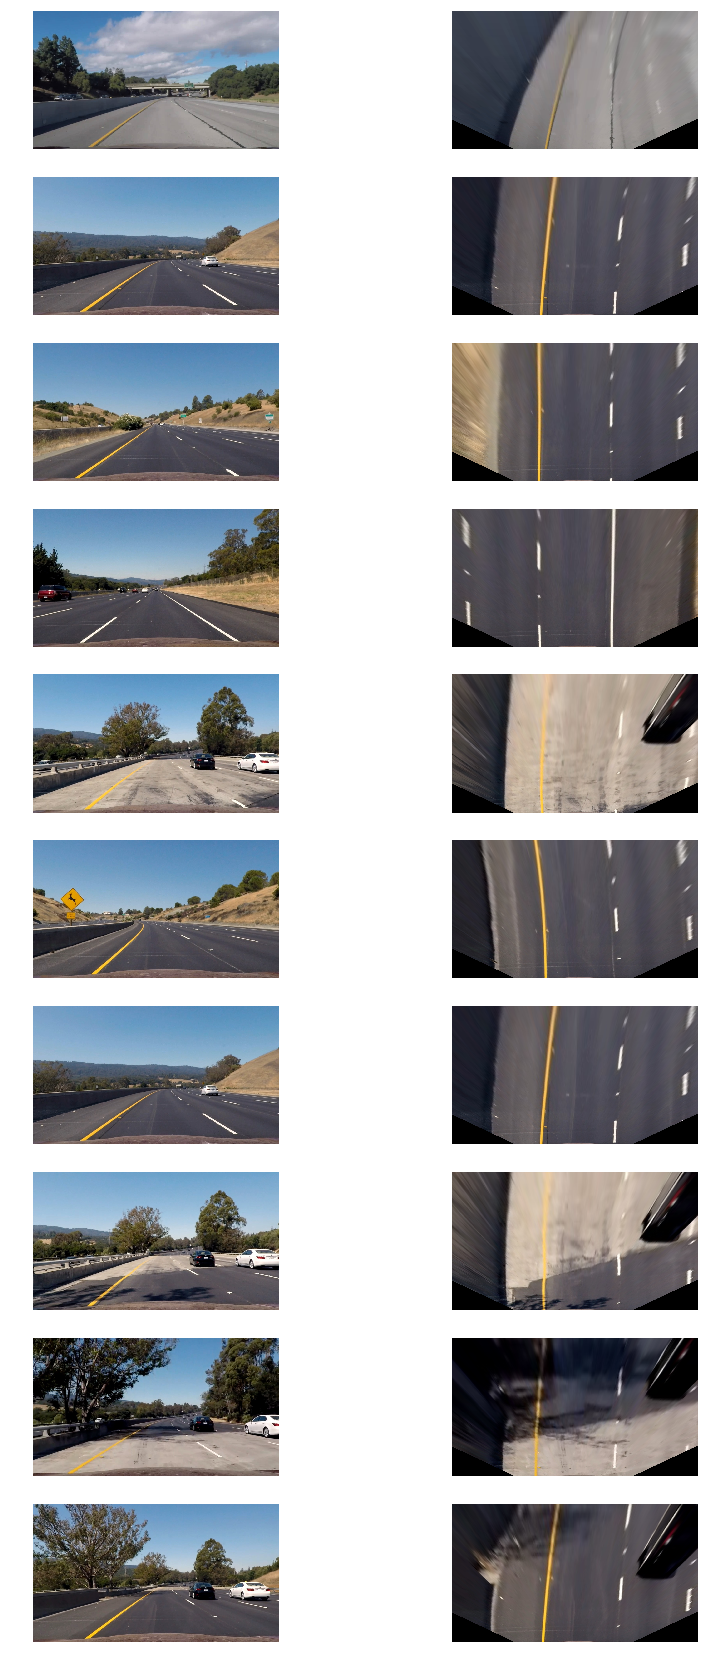

In [10]:
def visual_warped_imgs():
    imgpaths = glob.glob('./test_images/*.jpg')
    rows = len(imgpaths)
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(15,30))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    ax_list = axes.ravel().tolist()
    for idx,filepath in enumerate(imgpaths):
        img = mpimg.imread(filepath)
        img = undistort_image(img)
        warped = warper(img, src, dst)
        ax_list[2*idx].imshow(img)
        ax_list[2*idx].axis('off')
        ax_list[2*idx+1].imshow(warped)
        ax_list[2*idx+1].axis('off')
visual_warped_imgs()

# Explore Color Spaces

Text(0.5,1,'HSV Image')

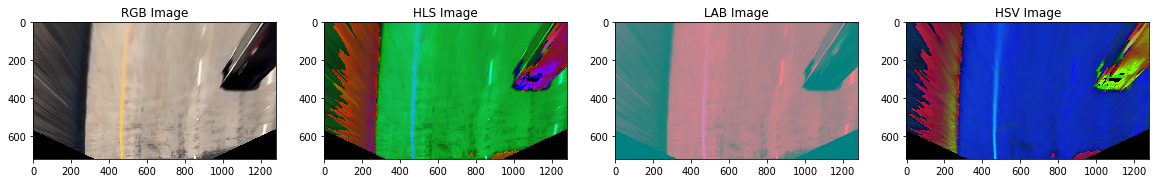

In [11]:
tmp_img = mpimg.imread('./test_images/test1.jpg')
tmp_img = undistort_image(tmp_img)

rgb_img = warper(tmp_img, src, dst)
hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
lab_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,16))
ax1.imshow(rgb_img)
ax1.set_title('RGB Image')

ax2.imshow(hls_img)
ax2.set_title('HLS Image')

ax3.imshow(lab_img)
ax3.set_title('LAB Image')

ax4.imshow(hsv_img)
ax4.set_title('HSV Image')

Text(0.5,1,'LAB B-Channel')

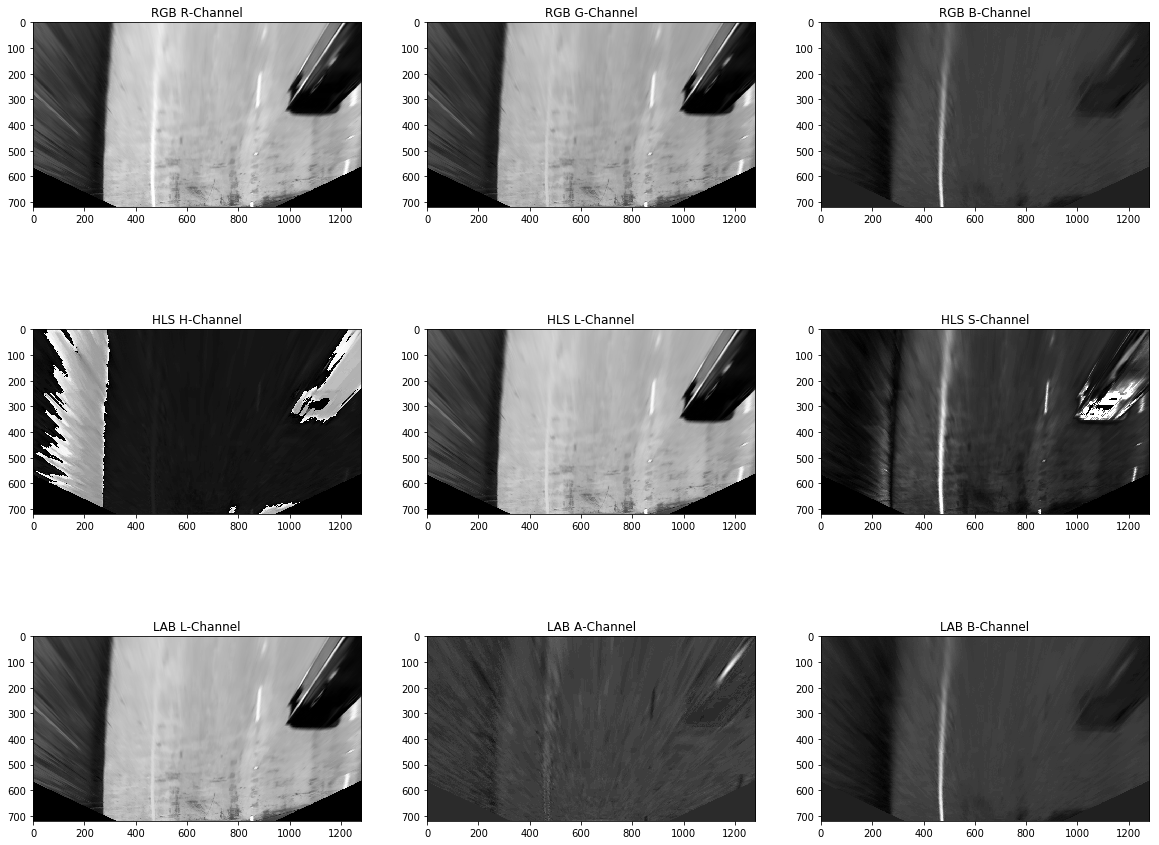

In [12]:
R = rgb_img[:,:,0]
G = rgb_img[:,:,1]
B = rgb_img[:,:,2]

H = hls_img[:,:,0]
L = hls_img[:,:,1]
S = hls_img[:,:,2]

L = lab_img[:,:,0]
A = lab_img[:,:,1]
B = lab_img[:,:,2]

fig, axes = plt.subplots(3, 3, figsize=(20,16))
axes = axes.ravel().tolist()

axes[0].imshow(R, cmap='gray')
axes[0].set_title('RGB R-Channel')

axes[1].imshow(G, cmap='gray')
axes[1].set_title('RGB G-Channel')
axes[2].imshow(B, cmap='gray')
axes[2].set_title('RGB B-Channel')

axes[3].imshow(H, cmap='gray')
axes[3].set_title('HLS H-Channel')
axes[4].imshow(L, cmap='gray')
axes[4].set_title('HLS L-Channel')
axes[5].imshow(S, cmap='gray')
axes[5].set_title('HLS S-Channel')

axes[6].imshow(L, cmap='gray')
axes[6].set_title('LAB L-Channel')
axes[7].imshow(A, cmap='gray')
axes[7].set_title('LAB A-Channel')
axes[8].imshow(B, cmap='gray')
axes[8].set_title('LAB B-Channel')


#### HLS-L Channel 

In [13]:
def hls_lthresh(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L = L*(255/np.max(L))
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

#### LAB-B Channel

In [14]:
def lab_bthresh(img, thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    B = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(B) > 175:
        B = B*(255/np.max(B))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(B)
    binary_output[((B > thresh[0]) & (B <= thresh[1]))] = 1
    return binary_output

#### Absolute Sobel Threshold

In [15]:
def abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return s_binary

#### Magnitude  Sobel Threshold

In [16]:
def magnitude_thresh(img, sobel_kernel=25, thresh_min=20, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return binary_output

#### Direction Sobel Threshold

In [17]:
def direction_thresh(img, sobel_kernel=9, thresh_min=0, thresh_max=0.1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh_min) & (direction <= thresh_max)] = 1
    # Return this mask as your binary_output image
    return binary_output

#### Compare Different Sobel Threshold Function

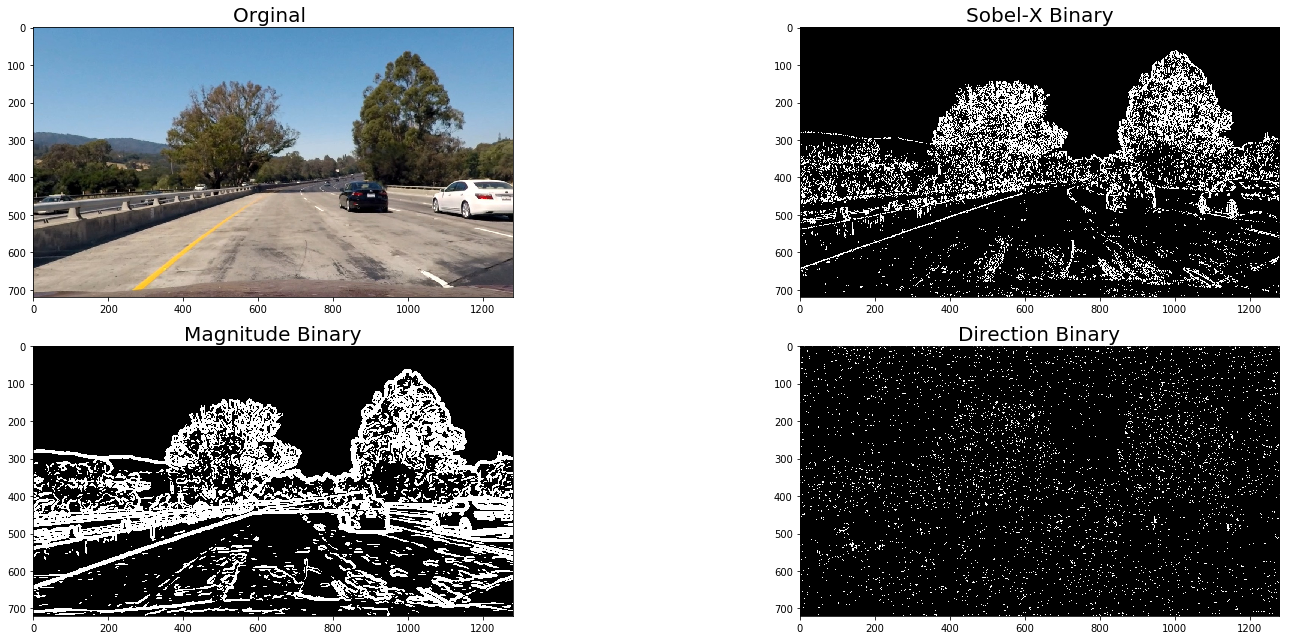

In [18]:
def explore_sobel_thresh(img):
    warped = np.copy(img)
    gradx_binary = abs_sobel_thresh(warped, 'x', 10, 150) # 10 150
    grady_binary = abs_sobel_thresh(warped, 'y', 10, 255)
    magnitude_binary = magnitude_thresh(warped, sobel_kernel=25, thresh_min=20, thresh_max=255)
    direction_binary = direction_thresh(warped, sobel_kernel=15, thresh_min=0, thresh_max=0.1)

    f, axes = plt.subplots(2, 2, figsize=(24, 9))
    (ax0, ax1, ax2, ax3) = axes.ravel()

    ax0.imshow(warped)
    ax0.set_title('Orginal ', fontsize=20)

    ax1.imshow(gradx_binary, cmap='gray')
    ax1.set_title('Sobel-X Binary', fontsize=20)

    ax2.imshow(magnitude_binary, cmap='gray')
    ax2.set_title('Magnitude Binary', fontsize=20)

    ax3.imshow(direction_binary, cmap='gray')
    ax3.set_title('Direction Binary', fontsize=20)

    plt.tight_layout()
explore_sobel_thresh(tmp_img)

# Pipeline

In [19]:
def pipeline(img):
    # Undistort
    undist = undistort_image(img)
    # Perspective Transform
    warped = warper(undist, src, dst)
    # HLS L-channel Threshold 
    img_L_channel = hls_lthresh(warped)
    # Lab B-channel Threshold
    img_B_channel = lab_bthresh(warped)
    # mag sobel 
    mag = magnitude_thresh(warped)
    # Combine HLS L and Lab B channel and Magnitude Thresh
    combined = np.zeros_like(img_L_channel)
    combined[((img_L_channel == 1) | (img_B_channel == 1)) & (mag == 1)] = 1
    return combined

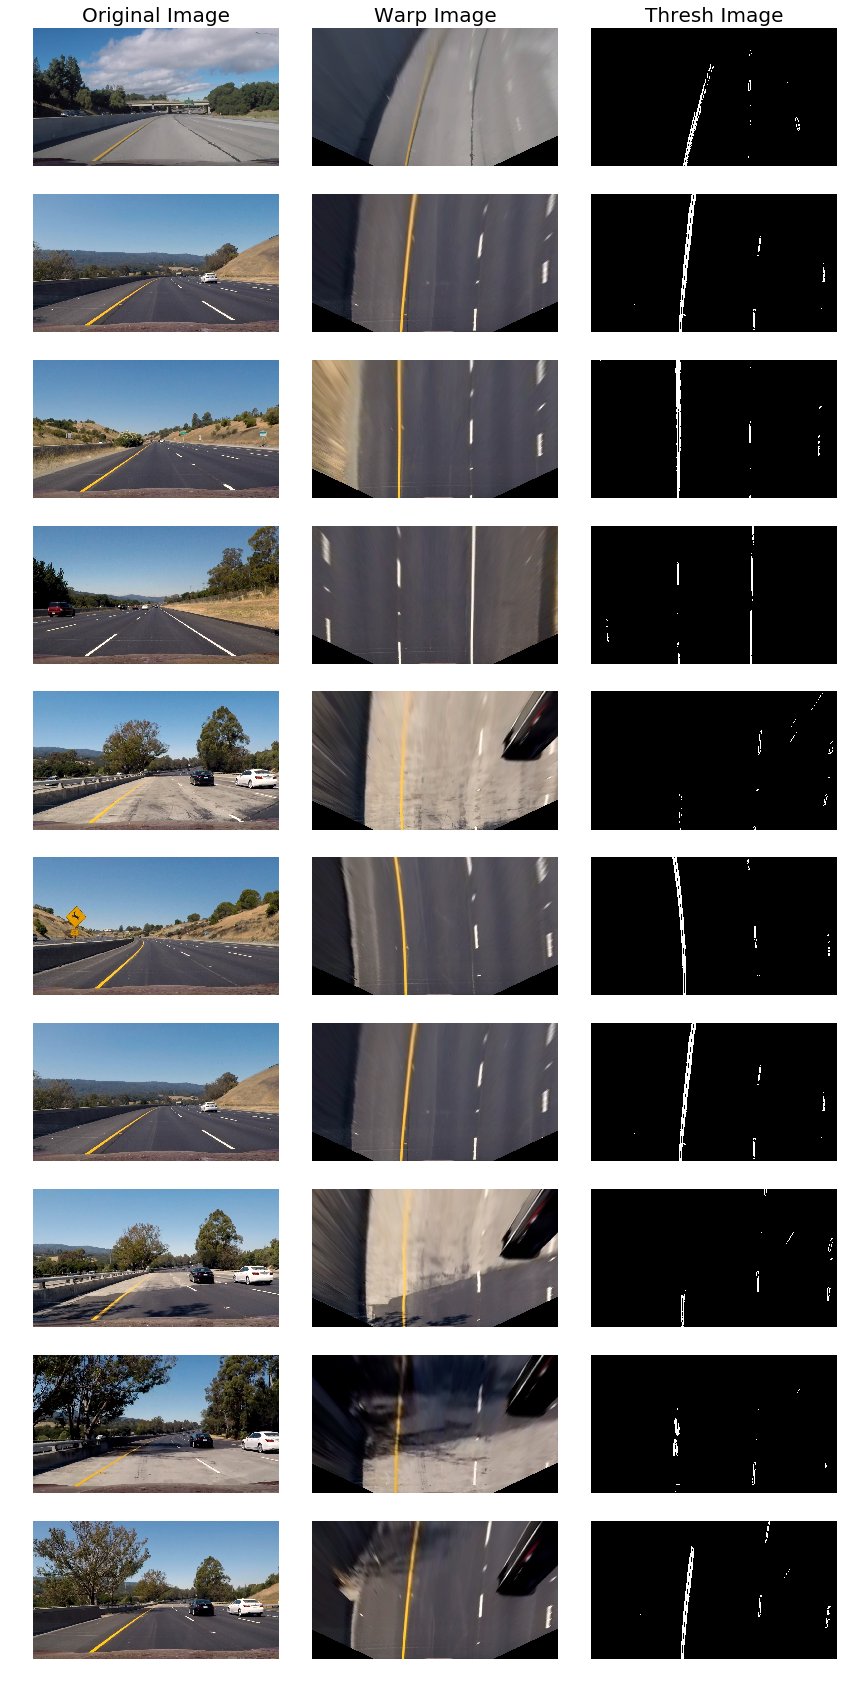

In [20]:
def visual_pipeline_imgs():
    imgpaths = glob.glob('./test_images/*.jpg')
    rows = len(imgpaths)
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15,30))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    ax_list = axes.ravel().tolist()
    for idx,filepath in enumerate(imgpaths):
        img = mpimg.imread(filepath)
        undist = undistort_image(img)
        warped = warper(undist, src, dst)
        combined_bin = pipeline(img)
        ax_list[3*idx].imshow(img)
        ax_list[3*idx].axis('off')
        ax_list[3*idx+1].imshow(warped, cmap='gray')
        ax_list[3*idx+1].axis('off')
        ax_list[3*idx+2].imshow(combined_bin, cmap='gray')
        ax_list[3*idx+2].axis('off')
    ax_list[0].set_title('Original Image', fontsize=20)
    ax_list[1].set_title('Warp Image', fontsize=20)
    ax_list[2].set_title('Thresh Image', fontsize=20)
visual_pipeline_imgs()

# Find Lane pixels

In [21]:
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9 #10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100 #80
    # Set minimum number of pixels found to recenter window
    minpix = 50 #40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

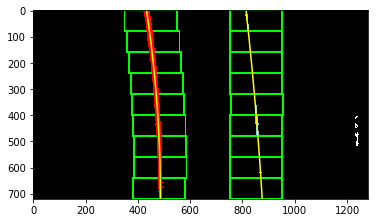

In [22]:
#visualize the result on example image
def visualize_sliding_window(img):

    img_bin = pipeline(img)

    plt.imshow(img_bin, cmap='gray')
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)

    h = img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 5) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 5) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return histogram

image2 = mpimg.imread('./test_images/test2.jpg')
his = visualize_sliding_window(image2)

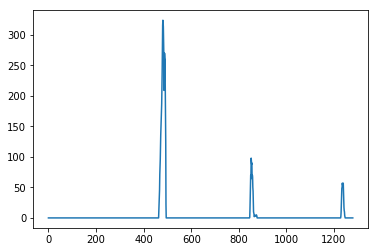

In [23]:
plt.plot(his)

# Search From Prior

In [24]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


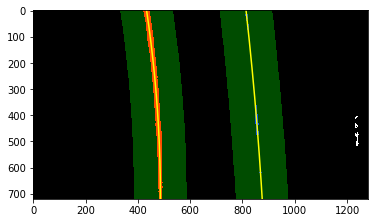

In [25]:
def test():
    # visualize the result on example image
    img = mpimg.imread('./test_images/test2.jpg')
    img_bin = pipeline(img)   
    margin = 100
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(img_bin, left_fit, right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
test()

# cal curvature

In [26]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [27]:
img = mpimg.imread('./test_images/my_test.jpg')
img_bin = pipeline(img)
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 1177.8772409363203 m, 580.5907964682766 m
Distance from lane center for example: -0.13664128245815393 m


In [28]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

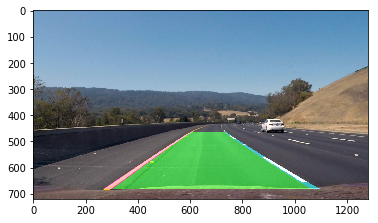

In [29]:
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img_bin)
img_out1 = draw_lane(img, img_bin, left_fit, right_fit, Minv)
plt.imshow(img_out1)

In [30]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is {:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

...


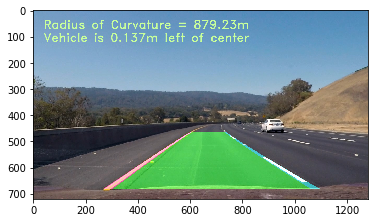

In [31]:
img_out2 = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(img_out2)
print('...')

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

...


In [ ]:
l_line = Line()
r_line = Line()

In [36]:
def process_image(img):
    new_img = np.copy(img)
    img_bin = pipeline(new_img)
    Minv = get_reversion_transformation_matrix(src, dst)
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    return img_out

In [37]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

In [40]:
video_src = VideoFileClip('project_video.mp4')
video_dst = 'project_video_output.mp4'
processed_video = video_src.fl_image(process_image)
%time processed_video.write_videofile(video_dst, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:16<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 17s
